1\. **Color-coded scatter plot**

Produce a scatter plot from a dataset with two categories.

* Write a function that generates a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and standard deviation. Set different values of the mean and stardand deviation between the two samples.
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below:

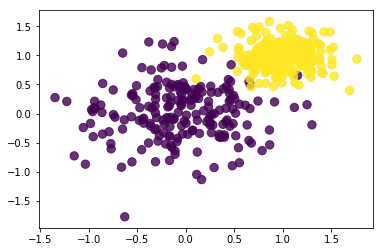

In [1]:
from IPython.display import Image
Image('two_categories_scatter_plot.png')

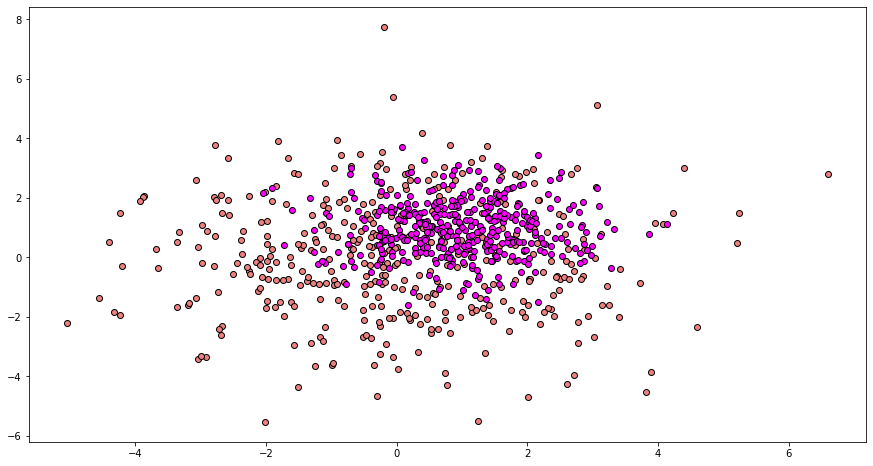

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def gaussian(mu1, mu2, sigma1, sigma2, size):
    a1 = np.random.normal(loc=mu1, scale=sigma1, size=size)
    b1 = np.random.normal(loc=mu1, scale=sigma1, size=size)
    a2 = np.random.normal(loc=mu2, scale=sigma2, size=size)
    b2 = np.random.normal(loc=mu2, scale=sigma2, size=size)
    return ((a1, b1),(a2, b2))
dataset = gaussian(0, 1, 2, 1, 400)

fig, ax = plt.subplots(figsize=(15, 8))
ax.scatter(dataset[0][0], dataset[0][1], marker='o', c='lightcoral', edgecolor='black')
ax.scatter(dataset[1][0], dataset[1][1], marker='o', c='fuchsia', edgecolor='black')

2\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following pickle file:
```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```
* Inspect the dataset, you'll find two variables (features)
* Convert the content to a Pandas Dataframe
* Clean the sample by selecting the entries (rows) with the absolute values of the variable "residual" smaller than 2
* Plot a Seaborn jointplot of "residuals" versus "distances", and use seaborn to display a linear regression. 

Comment on the correlation between these variables.

* Create manually (without using seaborn) the profile histogram for the "distance" variable; choose an appropriate binning.
* Obtain 3 numpy arrays:
  * `x`, the array of bin centers of the profile histogram of the "distance" variable
  * `y`, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * `err_y`, the standard deviation of the of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

{'residuals': array([ 1.1       , -1.95      , -7.2       , ...,  0.08333333,
        0.16666667,  0.08333333]), 'distances': array([16. ,  6.3,  3.4, ...,  1.7, 19.1,  2.6])}
Dataframe
        residuals  distances
0       1.100000       16.0
1      -1.950000        6.3
2      -7.200000        3.4
3      -4.150000        8.4
4      -6.590000        1.7
...          ...        ...
11126  -0.760000       14.4
11127   0.380000        7.5
11128   0.083333        1.7
11129   0.166667       19.1
11130   0.083333        2.6

[11131 rows x 2 columns]
Clean the dataframe
        residuals  distances
0       1.100000       16.0
1      -1.950000        6.3
8      -0.042857        3.3
9       0.128571        5.3
10      0.085714       15.0
...          ...        ...
11126  -0.760000       14.4
11127   0.380000        7.5
11128   0.083333        1.7
11129   0.166667       19.1
11130   0.083333        2.6

[10489 rows x 2 columns]


Text(0, 0.5, 'Residuals')

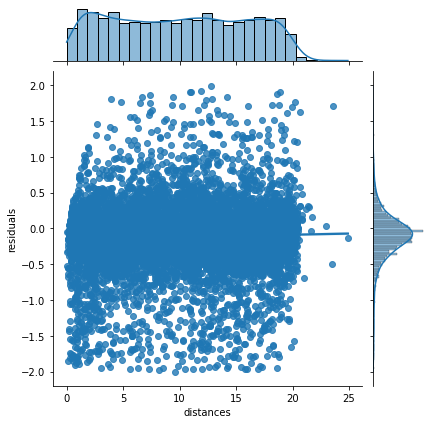

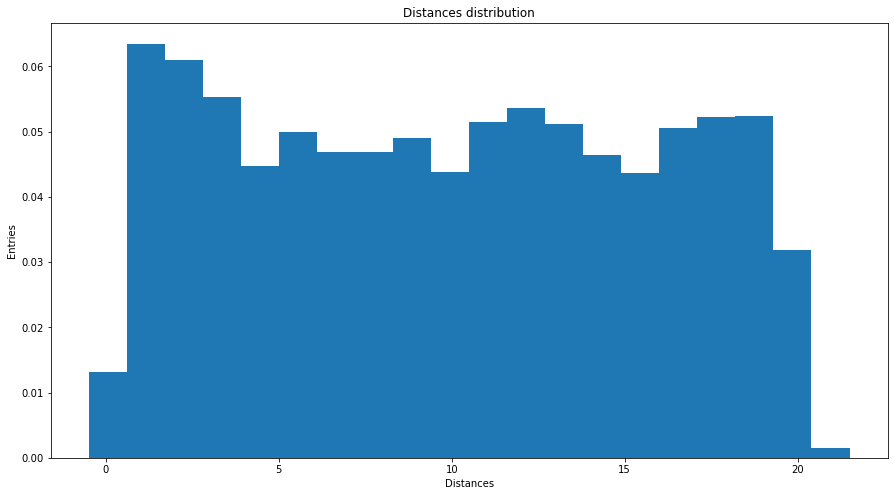

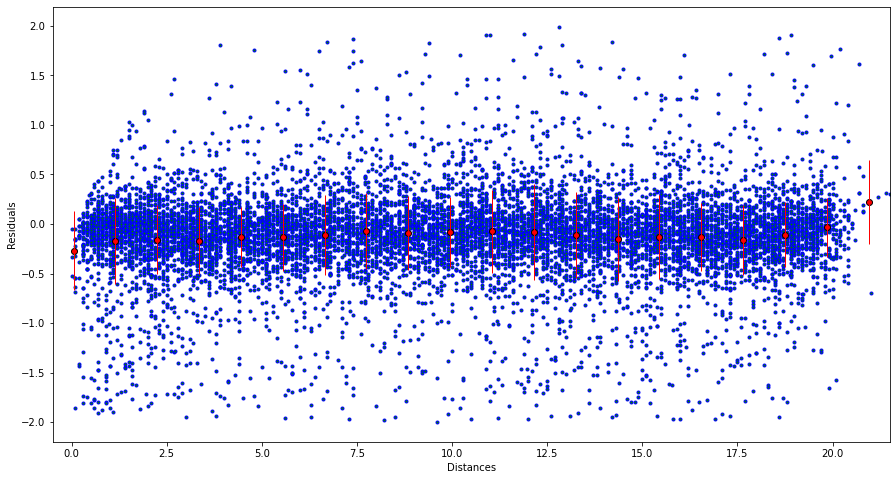

In [31]:
import pickle
import pandas as pd
import numpy as np
from matplotlib import collections  as mc

with open('residuals_261.pkl', 'rb') as f:
    data = pickle.load(f)
    print(data)

dic = data[()]
df = pd.DataFrame(dic)
print('Dataframe\n', df)

c_df = df[abs(df['residuals'])<2]
print('Clean the dataframe\n', c_df)


import seaborn as sns
g = sns.jointplot(x='distances', y='residuals', data=c_df, kind='reg')


distan = list(c_df['distances'])
fig, ax = plt.subplots(figsize=(15, 8))
h, bins, _ = plt.hist(distan, bins=20, range=(-0.5, 21.5), density=True, cumulative=False)
ax.set_title('Distances distribution')
ax.set_xlabel('Distances')
ax.set_ylabel('Entries')
bin_ranges = list(zip(bins,bins[1:]))

centers = [(x[1]+x[0])/2 for x in bin_ranges]


means = np.empty(len(bin_ranges))
variances = np.empty(len(bin_ranges))
for bin_index, interval in enumerate(bin_ranges):
    residuals=[]
    for index, row in c_df.iterrows():
        if (interval[0]<row['distances']) and (row['distances']<interval[1]):
            residuals.append(row['residuals'])
    if len(residuals)==0:
        np.append(means, np.nan)
        np.append(variances, np.nan)
    else:
        means[bin_index] = sum(residuals)/len(residuals)
        variances[bin_index] = np.var(residuals)


fig, ax = plt.subplots(figsize=(15, 8))
ax.scatter(c_df['distances'], c_df['residuals'], marker='.', c='g', edgecolor='b')
ax.scatter(centers, means, marker='o', c='r', edgecolor='k')

lines = [[(x[0], x[1]-2*x[2]), (x[0], x[1]+2*x[2])] for x in zip(centers,means, variances)]
lc = mc.LineCollection(lines, colors='r', linewidths=1)
ax.add_collection(lc)
plt.gca().set_xlim(left=-0.5, right=21.5)
ax.set_xlabel('Distances')
ax.set_ylabel('Residuals')


3\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn):

* Fill a numpy array `x` of length N (with $N=\mathcal{O}(100)$) with a variable normally distributed, with a given mean and standard deviation
* Fill an histogram in pyplot taking proper care of the aesthetic:
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* For every element of `x`, create a gaussian with the mean corresponding to the element value and the standard deviation as a parameter that can be tuned. The standard deviation default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with `np.sum()`) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method. Superimpose the normalized sum of all gaussians to the first histogram.


In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.integrate import trapz
from matplotlib.ticker import AutoMinorLocator, MultipleLocator

x = np.random.normal(loc=3, scale=2, size=100)